In [1]:
import glob
import os
import random
import xml.etree.ElementTree as ET
from pathlib import Path
import cv2 as cv
import numpy as np
import scipy
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [26]:
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

In [27]:
def get_image(annot):
    img_path = './images/'
    file = annot.split('\\')
    img_filename = img_path + file[-2]+'/'+file[-1]+'.jpg'
    return img_filename

In [28]:
def image_resizing(dog_images, annotations):
    for i in range(len(dog_images)):
        bbox = get_bounding_boxes(annotations[i])
        dog = get_image(annotations[i])
        image = Image.open(dog)
        for j in range(len(bbox)):
            image_2 = image.crop(bbox[j])
            image_2 = image_2.resize((100,100), Image.ANTIALIAS)
            new_path = dog.replace('./images/','./Cropped/')
            new_path = new_path.replace('.jpg','-' + str(j) + '.jpg')
            image_2 = image_2.convert('RGB')
            head, tail = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)
            image_2.save(new_path)

In [29]:
dog_images = glob.glob("./images/*/*")
annotations = glob.glob("./annotations/*/*")
image_resizing(dog_images, annotations)

C:\Users\noill\AppData\Local\Temp\ipykernel_15612\2053523621.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image_2 = image_2.resize((100,100), Image.ANTIALIAS)


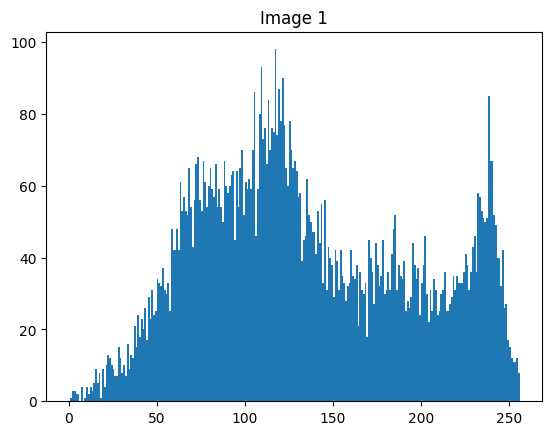

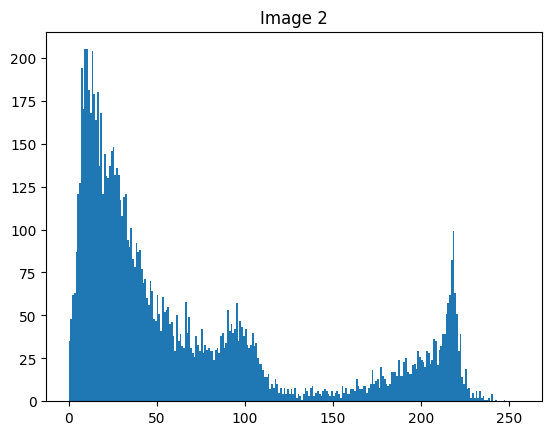

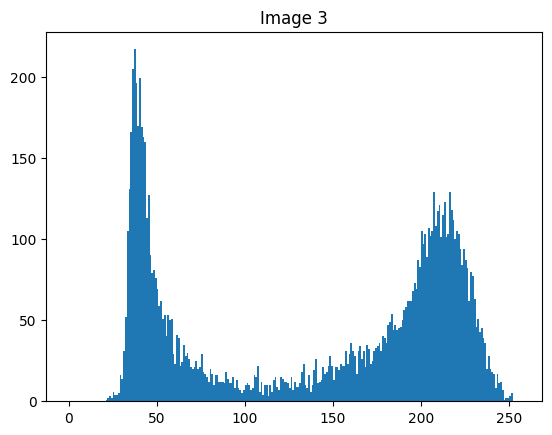

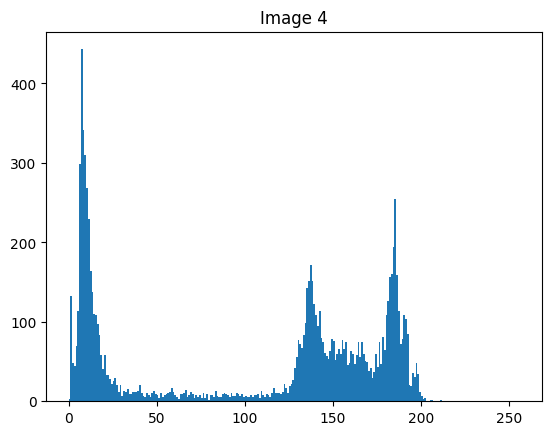

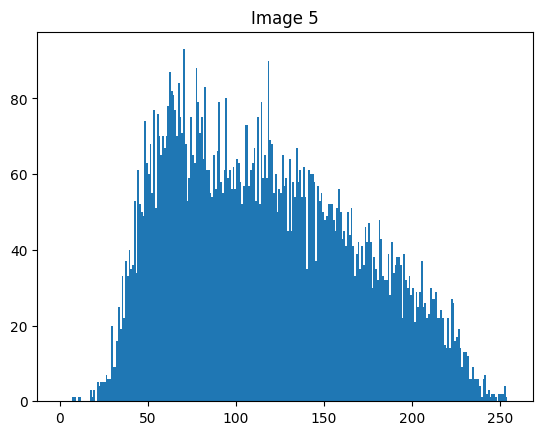

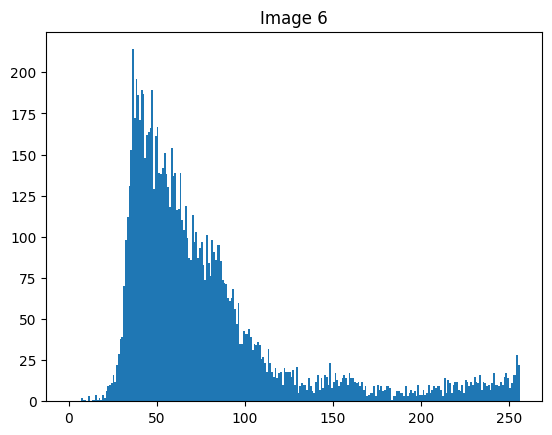

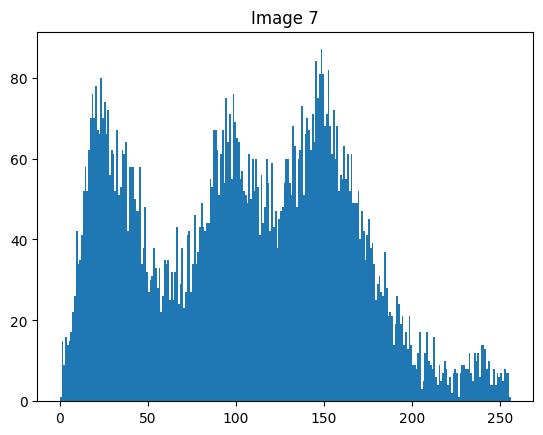

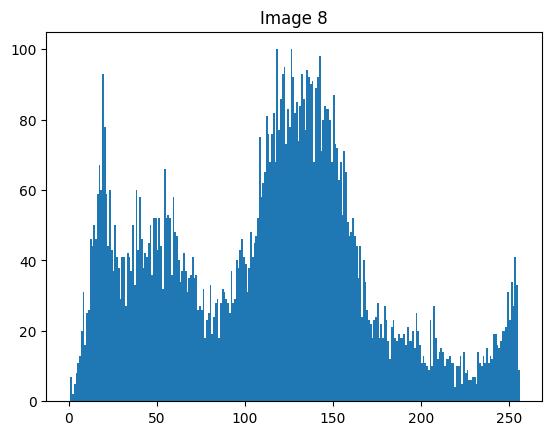

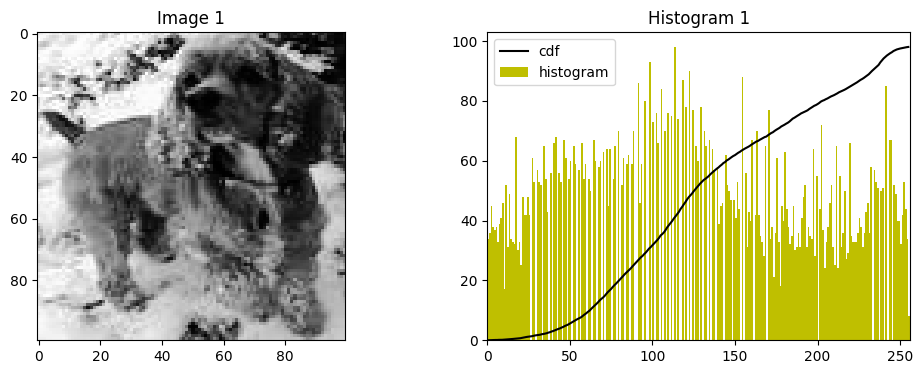

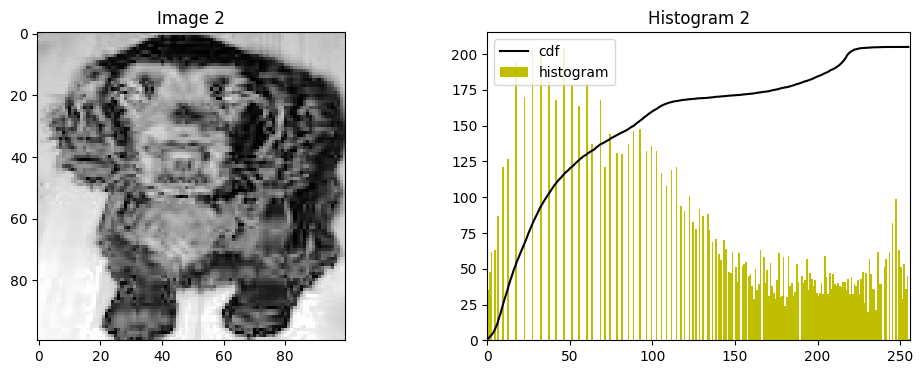

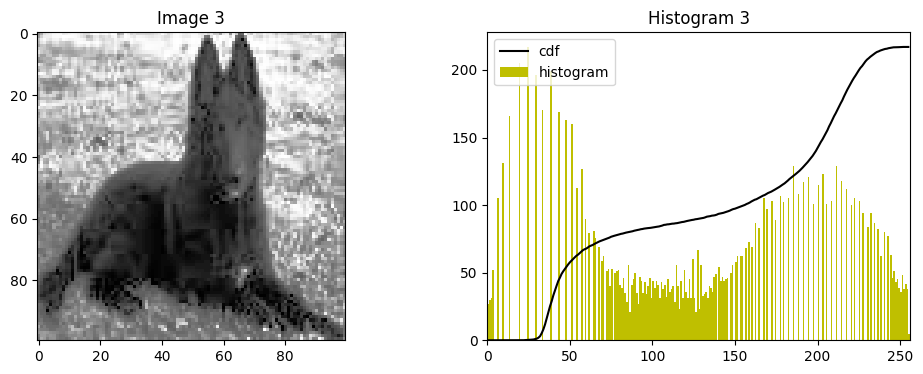

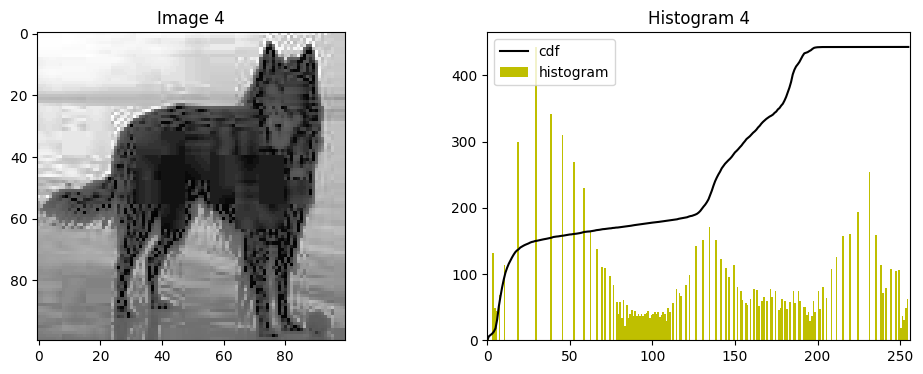

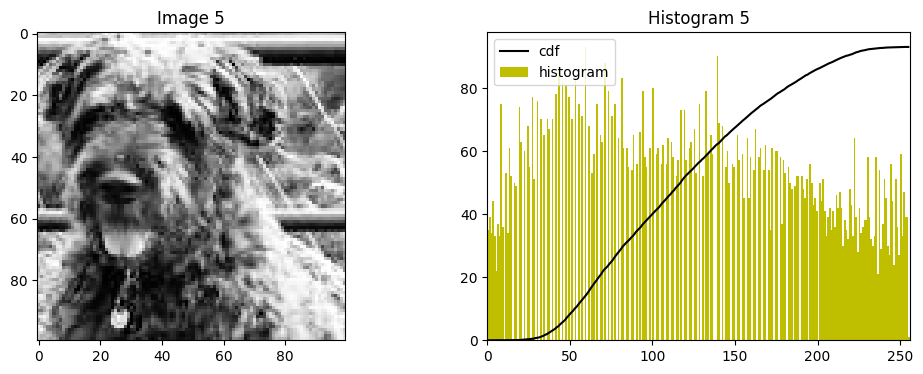

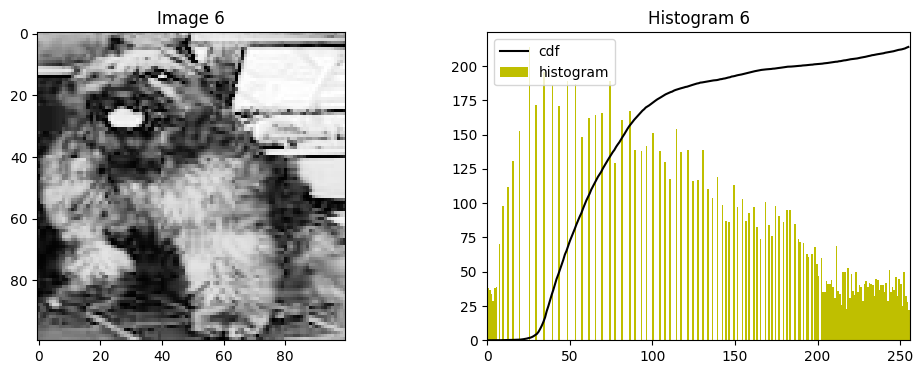

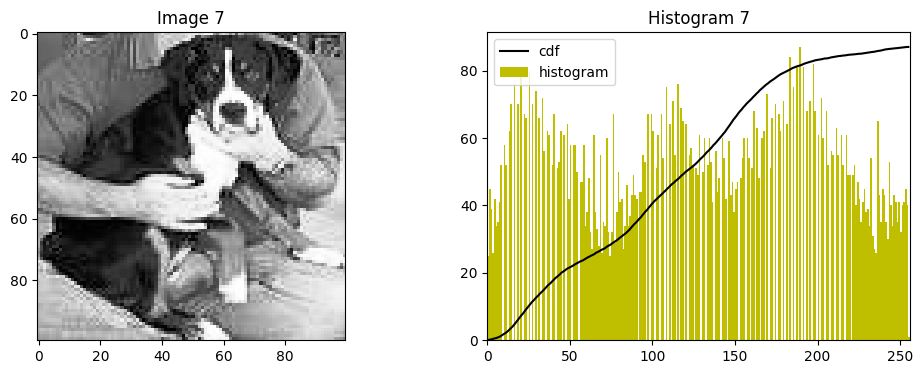

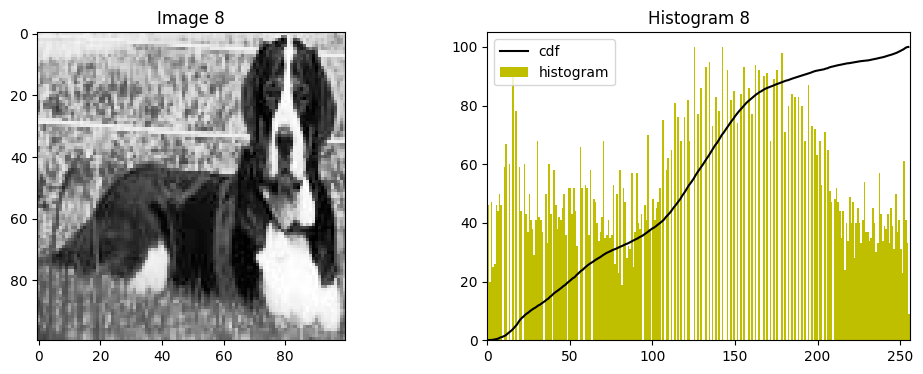

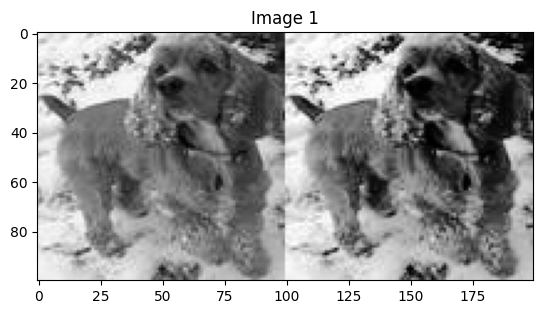

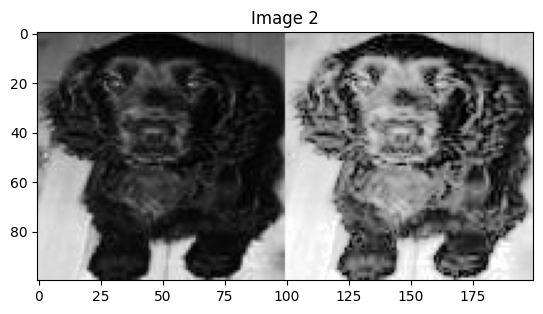

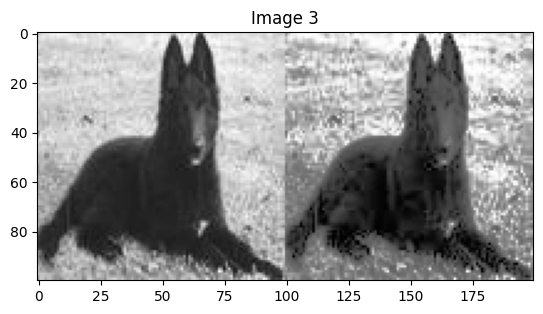

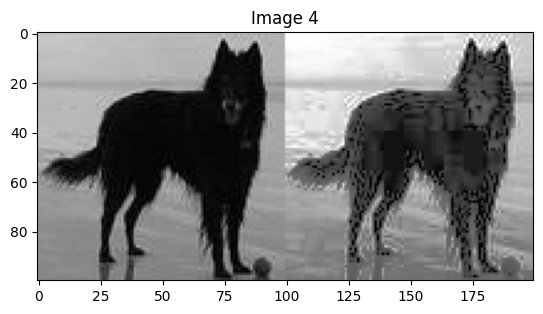

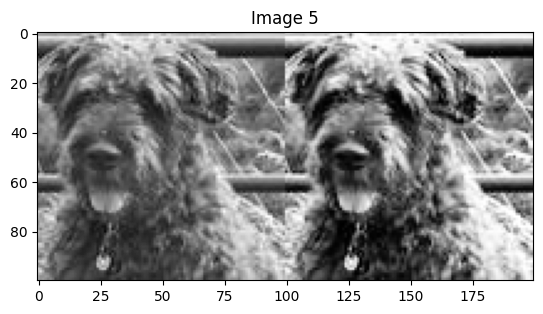

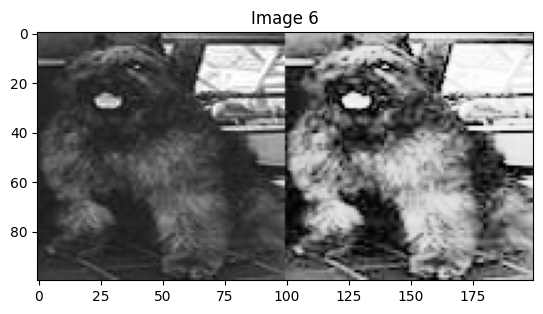

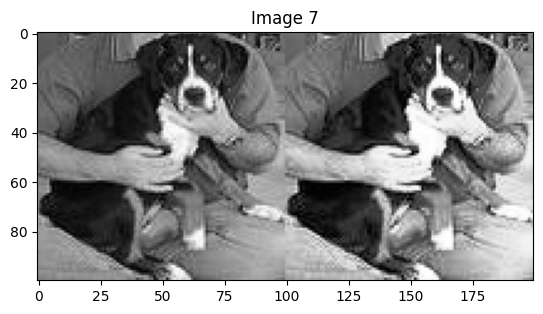

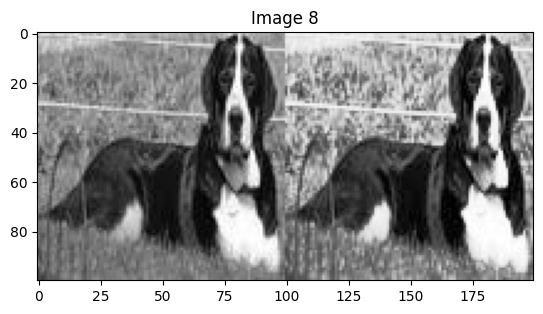

What I observed when I plotted the images side by side is the equalized image is a bit brighter or has a lighter color than the grayscaled one.


In [36]:
def image_intensity_normalization():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    collect = {}
    for folder in folders:
        random_files = random.sample(os.listdir(f"./Cropped/{folder}"), 2)
        collect[folder] = random_files


    # convert image to grayscale   
    grayscale_images = []    
    for folder, image in collect.items():        
        for img in image:
            path = f"./Cropped/{folder}/{img}"
            loaded_image = cv.imread(path)
            grayscale_images.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))


    # plot 8 grayscale image
    count = 1
    for image in grayscale_images:
        assert image is not None
        plt.hist(image.ravel(), 256, [0, 256])
        plt.title(f"Image {count}")
        count += 1
        plt.show()


    # perform and plot histogram equalization
    count = 1
    for image in grayscale_images:
        assert image is not None
        histogram, bins = np.histogram(image.flatten(), 256, [0,256])
        cdf = histogram.cumsum()
        cdf_normalized = cdf * float(histogram.max()) / cdf.max()
        equ = cv.equalizeHist(image)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(equ, cmap="gray")
        plt.title(f"Image {count}")

        cdf_m = np.ma.masked_equal(cdf,0)
        cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
        cdf = np.ma.filled(cdf_m,0).astype('uint8')
        img = cdf[image]

        plt.subplot(1, 2, 2)
        plt.plot(cdf_normalized, color = 'k')   
        plt.hist(img.flatten(), 256, [0, 256], color = 'y')
        plt.xlim([0, 256])
        plt.legend(('cdf', 'histogram'), loc = 'upper left')
        plt.title(f"Histogram {count}")
        count += 1
        plt.show()


    # plot grayscale and equalized next to each other
    count = 1
    for image in grayscale_images:
        assert image is not None    
        equ = cv.equalizeHist(image)
        res = np.hstack((image, equ))
        plt.imshow(res, cmap="gray")
        plt.title(f"Image {count}")
        count += 1
        plt.show()

    print("What I observed when I plotted the images side by side is the equalized image is a bit brighter or has a lighter color than the grayscaled one.")

    
image_intensity_normalization()

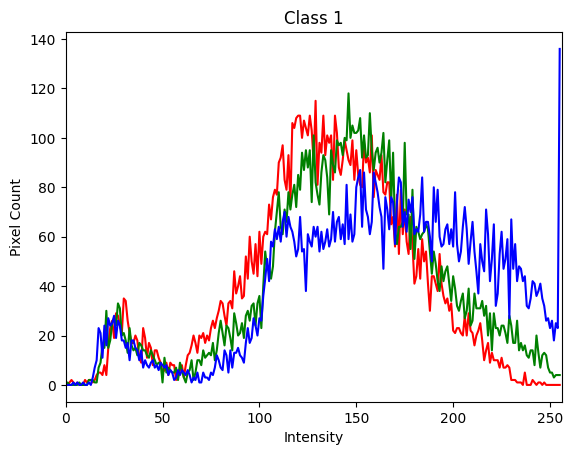

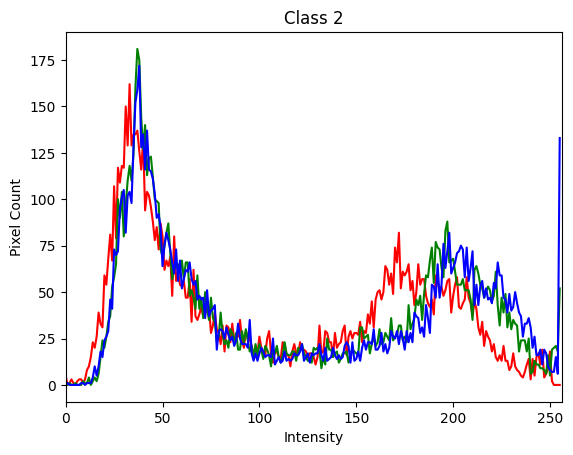

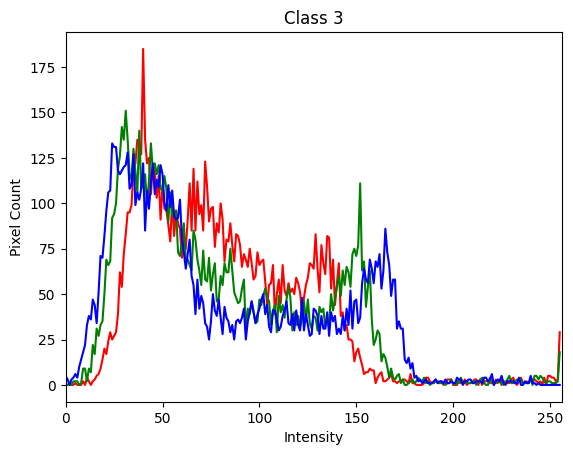

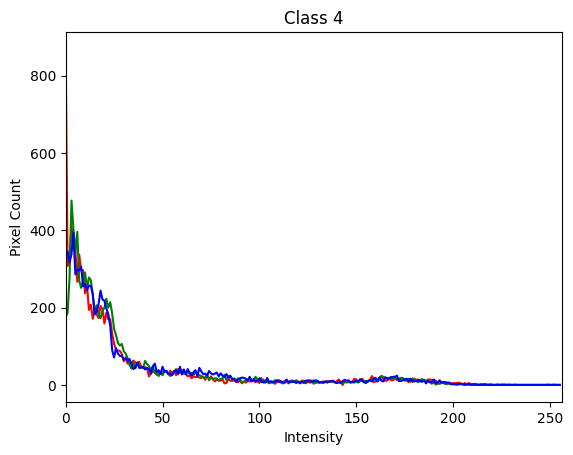

In [31]:
def rgb_histogram():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    collect = {}
    for folder in folders:
        random_files = random.sample(os.listdir(f"./Cropped/{folder}"), 1)
        collect[folder] = random_files



    loaded_images = []
    for folder, image in collect.items():        
        for img in image:
            path = f"./Cropped/{folder}/{img}"
            loaded_images.append(cv.imread(path))


    # plot images with RGB histogram
    count = 1
    for image in loaded_images:
        assert image is not None
        colors = ('r', 'g', 'b')

        for i, color in enumerate(colors):
            hist = cv.calcHist([image], [i], None, [256], [0,256])
            plt.plot(hist, color = color)
            plt.xlim([0, 256])
            plt.xlabel("Intensity")
            plt.ylabel("Pixel Count")
            plt.title(f"Class {count}")

        count += 1
        plt.show()

        
rgb_histogram()

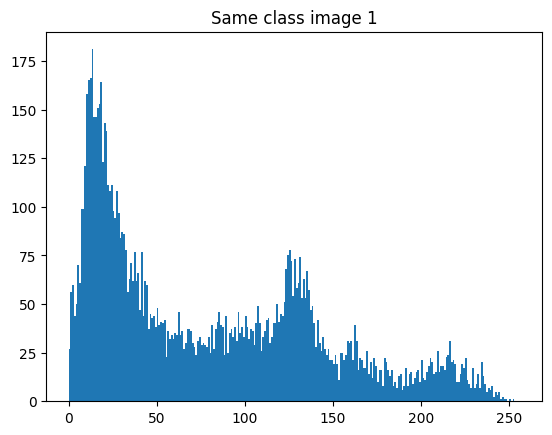

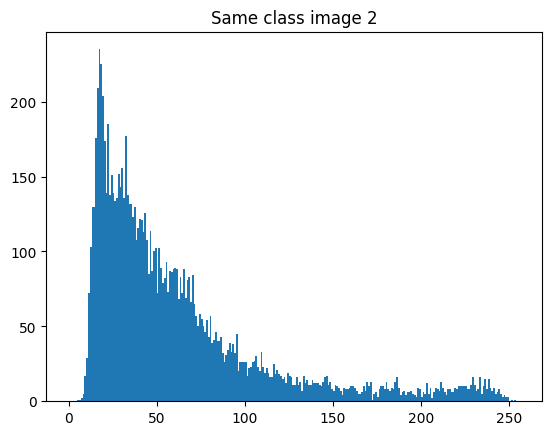

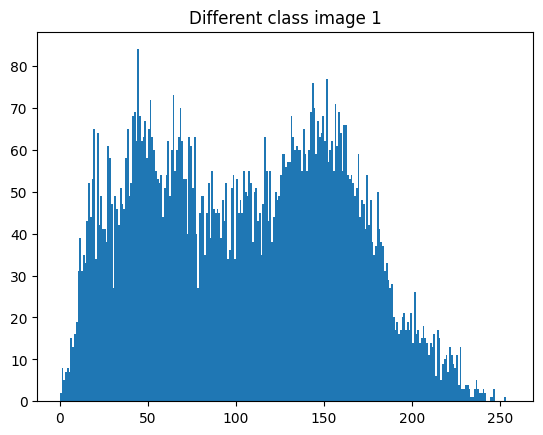

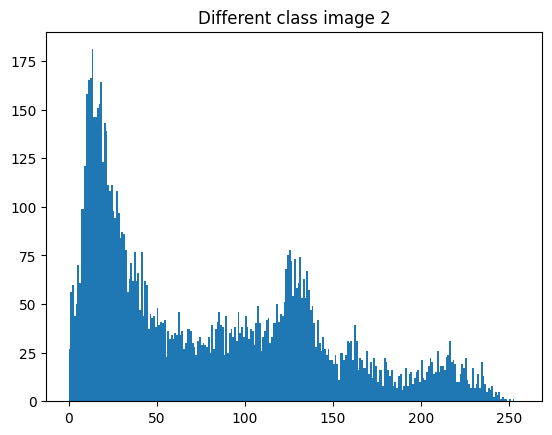

Same classes
Euclidean distance: 0.0
Manhattan distance: 0
Bhattacharyya distance: 1.0536712127723509e-08
Histogram interesection: 792606.0


Different classes
Euclidean distance: 13178.685404849757
Manhattan distance: 1101813
Bhattacharyya distance: 0.36714011218530185
Histogram interesection: 554141.0


In [2]:
def histogram_comparison():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]

    count = 2
    folders = random.sample(folders, count)
    collect = {}
    for folder in folders:
        random_files = random.sample(os.listdir(f"./Cropped/{folder}"), count)
        collect[folder] = random_files
        count -= 1

    # convert image to grayscale   
    same_class_grayscale_images = []   
    diff_class_grayscale_images = []
    for folder, image in collect.items():     
        for img in image:
            path = f"./Cropped/{folder}/{img}"
            loaded_image = cv.imread(path)
            grayscale = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
            if list(collect.keys())[0] == folder:
                same_class_grayscale_images.append(grayscale)
            else:
                diff_class_grayscale_images.append(grayscale)
                diff_class_grayscale_images.append(same_class_grayscale_images[0])


    # histogram comparison

    # same class
    count = 1
    for image in same_class_grayscale_images:
        assert image is not None
        plt.hist(image.ravel(), 256, [0, 256])
        plt.title(f"Same class image {count}")
        count += 1    
        plt.show()


    # different class 
    count = 1
    for image in diff_class_grayscale_images:
        assert image is not None
        plt.hist(image.ravel(), 256, [0, 256])
        plt.title(f"Different class image {count}")
        count += 1 
        plt.show()


    # histogram comparison using metrics

    # same class
    print("Same classes")
    from scipy.spatial.distance import euclidean 
    # Euclidean distance
    same_ed = euclidean(same_class_grayscale_images[0].flatten(), same_class_grayscale_images[1].flatten())
    print(f"Euclidean distance: {same_ed}")

    # Manhattan distance
    same_md = np.sum(np.abs(same_class_grayscale_images[0] - same_class_grayscale_images[1]))
    print(f"Manhattan distance: {same_md}")

    # Bhattacharyya distance
    same_bd = cv.compareHist(same_class_grayscale_images[0].astype(np.float32), same_class_grayscale_images[1].astype(np.float32), cv.HISTCMP_BHATTACHARYYA)
    print(f"Bhattacharyya distance: {same_bd}")

    # Histogram intersection
    same_hi = cv.compareHist(same_class_grayscale_images[0].astype(np.float32), same_class_grayscale_images[1].astype(np.float32), cv.HISTCMP_INTERSECT)
    print(f"Histogram interesection: {same_hi}")


    # different class
    print("\n\nDifferent classes")
    # Euclidean distance
    diff_ed = np.linalg.norm(diff_class_grayscale_images[0] - diff_class_grayscale_images[1])
    print(f"Euclidean distance: {diff_ed}")

    # Manhattan distance
    diff_md = np.sum(np.abs(diff_class_grayscale_images[0] - diff_class_grayscale_images[1]))
    print(f"Manhattan distance: {diff_md}")

    # Bhattacharyya distance
    diff_bd = cv.compareHist(diff_class_grayscale_images[0].astype(np.float32), diff_class_grayscale_images[1].astype(np.float32), cv.HISTCMP_BHATTACHARYYA)
    print(f"Bhattacharyya distance: {diff_bd}")

    # Histogram intersection
    diff_hi = cv.compareHist(diff_class_grayscale_images[0].astype(np.float32), diff_class_grayscale_images[1].astype(np.float32), cv.HISTCMP_INTERSECT)
    print(f"Histogram interesection: {diff_hi}")
    
    
histogram_comparison()

Number fo keypoints extracted: 30


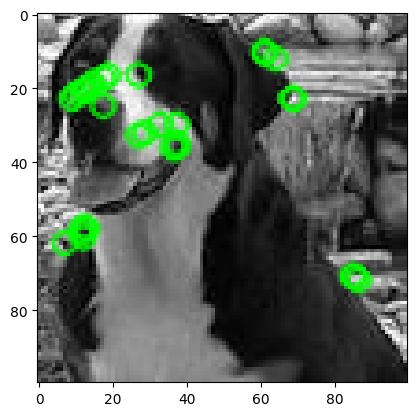

Number fo keypoints extracted between 25 and 75: 75


edge threshold is a parameter that helps detect edges of the image, where after that point it should ignore or not detect.

patchSize is a parameter that is the size of the patch, which helps compute the keypoints descriptor.



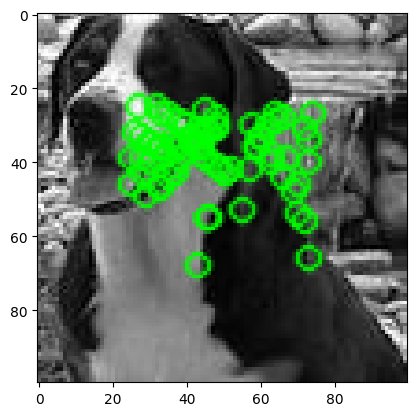

In [37]:
def image_feature_descriptor():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]

    collect = {}
    folder = random.sample(folders, 1)[0]
    random_files = random.sample(os.listdir(f"./Cropped/{folder}"), 1)
    collect[folder] = random_files


    # grayscale image
    img = collect[folder][0]
    path = f"./Cropped/{folder}/{img}"
    loaded_image = cv.imread(path)
    img = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)


    # peform keypoint extraction
    orb = cv.ORB_create(edgeThreshold=7, patchSize=10, nlevels=8, fastThreshold=20, scaleFactor=1.2, 
                                WTA_K=2,scoreType=cv.ORB_HARRIS_SCORE, firstLevel=0, nfeatures=30)
    kp = orb.detect(img, None)
    print(f"Number fo keypoints extracted: {len(kp)}")
    
    
    # plotting
    img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
    plt.imshow(img2)
    plt.show()

    orb = cv.ORB_create(edgeThreshold=25, patchSize=30, nlevels=8, fastThreshold=20, scaleFactor=1.2, 
                                WTA_K=2,scoreType=cv.ORB_HARRIS_SCORE, firstLevel=0)
    kp = orb.detect(img, None)
    if len(kp) > 75:
        kp = kp[:75]
    while len(kp) < 25:
        kp = orb.detect(img, None)
    print(f"Number fo keypoints extracted between 25 and 75: {len(kp)}")

    # I got their meanings from opencv github pages
    print("\n\nedge threshold is a parameter that helps detect edges of the image, where after that point it should ignore or not detect.")

    print("\npatchSize is a parameter that is the size of the patch, which helps compute the keypoints descriptor.\n")


    # plotting
    img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
    plt.imshow(img2)
    plt.show()
    
    
image_feature_descriptor()

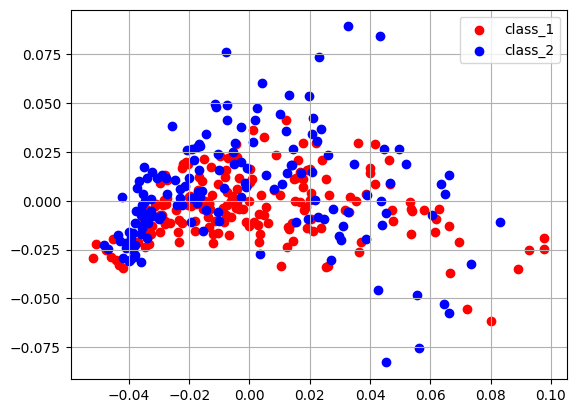

[0.26557937 0.13387402]

There is 26.6% total variance in the data for the first principal component and 13.4% total variance in the data for the second principal component, so we can say the two data is not separable


In [51]:
def dimensionality_reduction():    
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    folders = random.sample(folders, 2)
    files = [f for f in os.listdir(f"./Cropped/{folders[0]}") if os.path.isfile(os.path.join(f"./Cropped/{folders[0]}", f))]
    no_of_images = [len(files)]

    files = [f for f in os.listdir(f"./Cropped/{folders[1]}") if os.path.isfile(os.path.join(f"./Cropped/{folders[1]}", f))]
    no_of_images.append(len(files))

    collect = {}
    for folder, count in zip(folders, no_of_images):
        random_files = random.sample(os.listdir(f"./Cropped/{folder}"), count)
        collect[folder] = random_files
        

    # convert image to grayscale   
    grayscale_images_class_1 = []
    grayscale_images_class_2 = []

    for img in collect[folders[0]]:    
        path = f"./Cropped/{folders[0]}/{img}"
        loaded_image = cv.imread(path)
        grayscale_images_class_1.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))

    for img in collect[folders[1]]:    
        path = f"./Cropped/{folders[1]}/{img}"
        loaded_image = cv.imread(path)
        grayscale_images_class_2.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))
        

    # normalizing the dataset
    class_1_data = []
    class_2_data = []

    for image in grayscale_images_class_1:
        assert image is not None
        histogram, bins = np.histogram(image.flatten(), 256, [0,256])
        histogram = histogram / histogram.sum().ravel()
        class_1_data.append(histogram)

    for image in grayscale_images_class_2:
        assert image is not None
        histogram, bins = np.histogram(image.flatten(), 256, [0,256])
        histogram = histogram / histogram.sum().ravel()
        class_2_data.append(histogram)
    class_data = np.concatenate((class_1_data, class_2_data), axis=0)

    
    # perfrom PCA dimension reduction
    transformed_data = []
    pca = PCA(n_components = 2) 
    transformed_data = pca.fit_transform(class_data)
    transformed_data_1 = transformed_data[:len(class_1_data)]
    transformed_data_2 = transformed_data[len(class_1_data):]
    

    # plotting
    plt.scatter(transformed_data_1[:, 0], transformed_data_1[:, 1], color='r')
    plt.scatter(transformed_data_2[:, 0], transformed_data_2[:, 1], color='b')
    plt.grid(True)
    plt.legend(("class_1", "class_2"), loc = "upper right")
    plt.show()
    
    return pca


pca_result = dimensionality_reduction()
print(pca_result.explained_variance_ratio_)
print("\nThere is 26.6% total variance in the data for the first principal component and \
13.4% total variance in the data for the second principal component, so we can say the two data is not separable")